<a href="https://www.kaggle.com/code/samithsachidanandan/building-a-hybrid-machine-learning-model?scriptVersionId=224646474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Importing the necessary  libraries

In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from datetime import date, timedelta

import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression

### Importing the Dataset

In [186]:
df = pd.read_csv('/kaggle/input/netflix-stock-price-2002-2025/Netflix Inc. (NFLX) Stock Price 2002-2025.csv')

### Basic Data Analysis

In [187]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Feb 25, 2025",989.4,994.4,955,977.24,977.24,"4,733,000"
1,"Feb 24, 2025","1,008.00","1,015.17",984.48,988.47,988.47,"4,426,200"
2,"Feb 21, 2025","1,029.42","1,032.38",999.39,"1,003.15","1,003.15","3,738,700"
3,"Feb 20, 2025","1,042.00","1,045.00","1,015.59","1,024.54","1,024.54","3,111,800"
4,"Feb 19, 2025","1,035.18","1,045.00","1,024.51","1,043.33","1,043.33","2,600,000"


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       5729 non-null   object
 1   Open       5729 non-null   object
 2   High       5727 non-null   object
 3   Low        5727 non-null   object
 4   Close      5727 non-null   object
 5   Adj Close  5727 non-null   object
 6   Volume     5727 non-null   object
dtypes: object(7)
memory usage: 313.4+ KB


In [189]:
df.describe().T

,count,unique,top,freq
Date,5729,5727,"Jul 15, 2015",2
Open,5729,4092,2.86,14
High,5727,4114,4.14,15
Low,5727,4113,1.61,16
Close,5727,4164,3.96,14
Adj Close,5727,4164,3.96,14
Volume,5727,5560,"14,634,900",3


In [190]:
df.isnull().sum()

Date         0
Open         0
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64

In [191]:
df.dropna(inplace=True)


In [192]:
df.columns

Index(['Date', 'Open ', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

### Converting the Data Type

In [193]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Convert numeric columns, removing commas if necessary
numeric_cols = ['Open ', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df[numeric_cols] = df[numeric_cols].replace(',', '', regex=True).astype(float)





### Setting the date Column as Index

In [194]:
df.set_index('Date', inplace=True)

### Plot the stock prices over time

<Figure size 1600x800 with 0 Axes>

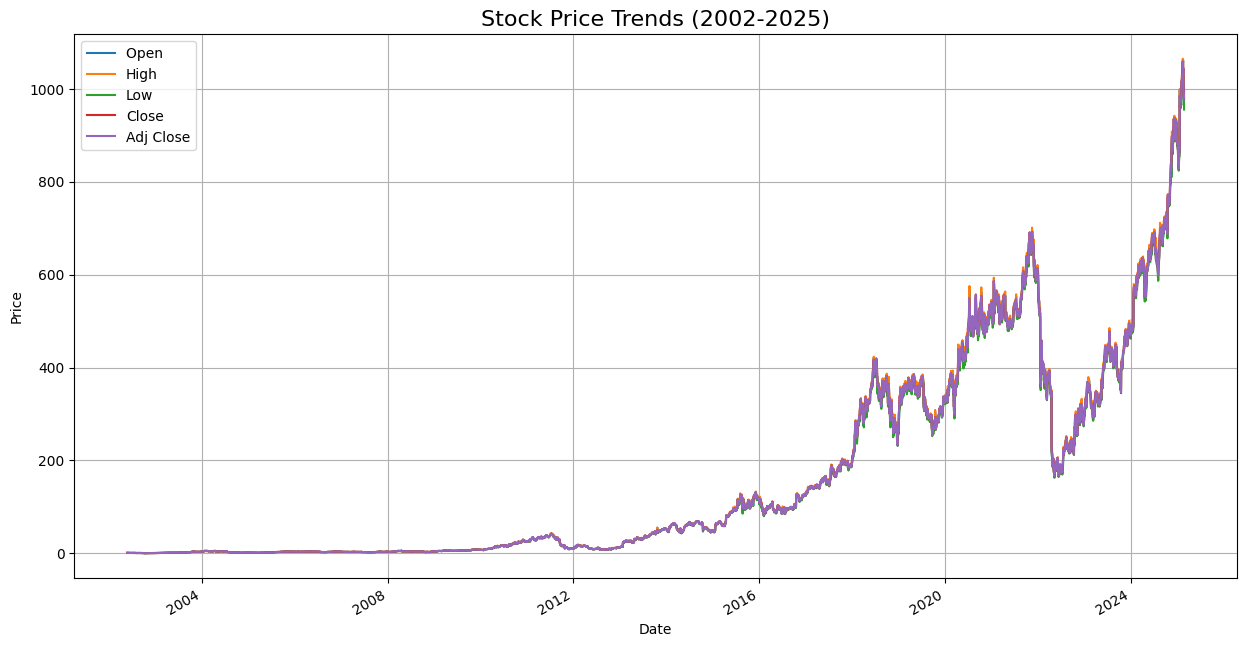

In [195]:
plt.figure(figsize=(16, 8))

# Plot open, high, low, close, prev_close
df[['Open ', 'High', 'Low', 'Close', 'Adj Close']].plot(figsize=(15, 8), linewidth=1.5)
plt.title('Stock Price Trends (2002-2025)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### Calculate moving averages

In [196]:
df['50_MA'] = df['Close'].rolling(window=50).mean()
df['200_MA'] = df['Close'].rolling(window=200).mean()

### Plot closing prices with moving averages

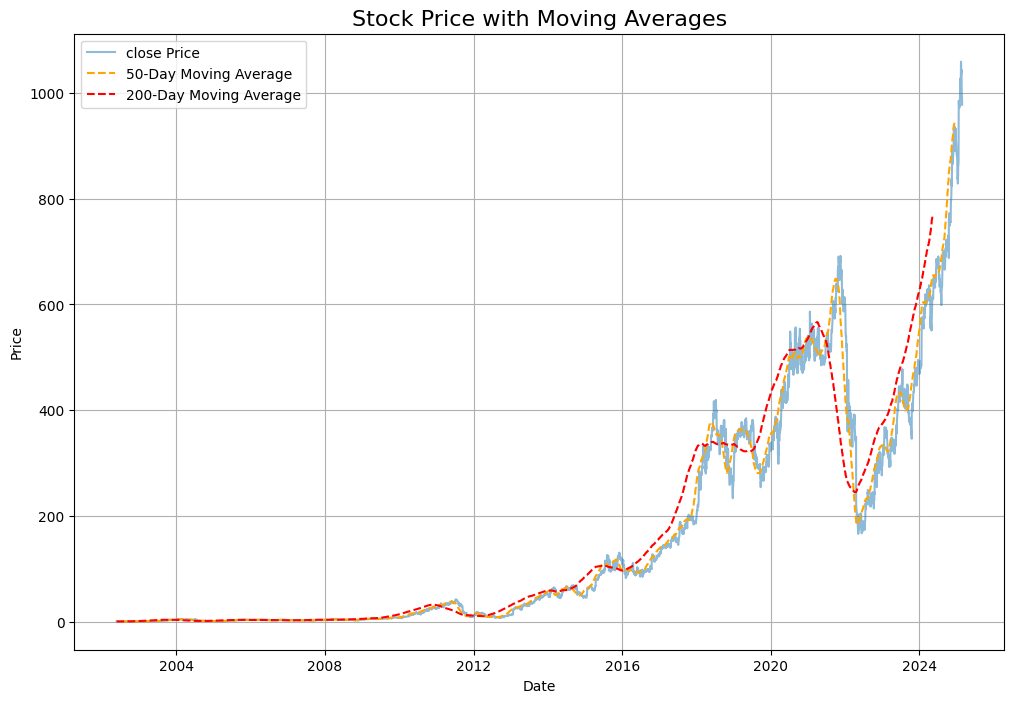

In [197]:
plt.figure(figsize=(12, 8))
plt.plot(df['Close'], label='close Price', alpha=0.5)
plt.plot(df['50_MA'], label='50-Day Moving Average', color='orange', linestyle='--')
plt.plot(df['200_MA'], label='200-Day Moving Average', color='red', linestyle='--')

plt.title('Stock Price with Moving Averages', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Calculate daily price range

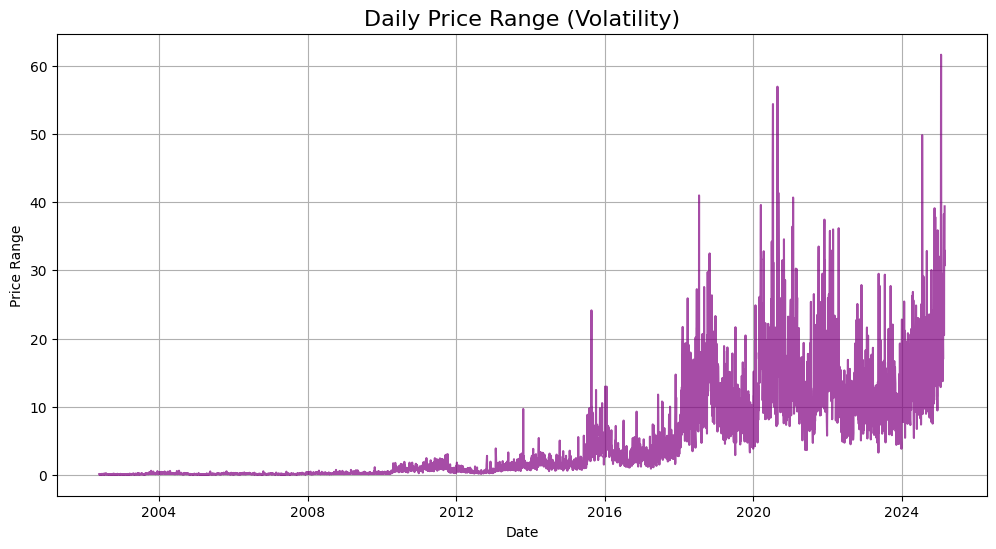

In [198]:
df['Daily Range'] = df['High'] - df['Low']

# Plot the daily range (volatility)
plt.figure(figsize=(12, 6))
plt.plot(df['Daily Range'], label='Daily Price Range', color='purple', alpha=0.7)

plt.title('Daily Price Range (Volatility)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price Range')
plt.grid(True)
plt.show()

### Filtering the Data

In [199]:
df = df.sort_index() 
start_date = '2024-02-27'
end_date = '2025-02-26'

df_filtered = df.loc[start_date:end_date]

In [200]:


# Plot interactive line chart for stock prices
fig = px.line(df_filtered, x=df_filtered.index, y=['Open ', 'High', 'Low', 'Close', 'Adj Close'],
              title='Stock Price Trends (Last 1 Years)')
fig.update_layout(xaxis_title='Date', yaxis_title='Price', template='plotly_dark')
fig.show()

### Selecting the Required Data

In [201]:

data = df_filtered[['Close']]

### Choosing the Hybrid Models

In [202]:
#scale the Close price data between 0 and 1 using MinMaxScaler to ensure compatibility with the LSTM model

scaler = MinMaxScaler(feature_range=(0, 1))
data = data.copy()
data['Close'] = scaler.fit_transform(data[['Close']])


#### Preparing  the data for LSTM by creating sequences of 60 days to predict the next day’s price:

In [203]:

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(data['Close'].values, seq_length)

### Spliting the Data 

In [204]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [219]:
X_train.shape


(152, 60)

#### We will build a sequential LSTM model with layers to capture the temporal dependencies in the data

In [206]:


lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

#### We will compile the model using an appropriate optimizer and loss function, and fit it into the training data

In [207]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0939
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0143
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0109
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0094
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0093
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0035
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0046
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0031
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0031
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0029
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0025
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0024
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0025
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0026
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0027
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━

### Training the Second Model 

In [208]:
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)
data['Lag_3'] = data['Close'].shift(3)
data = data.dropna()

### Splitting the train and test

In [209]:
X_lin = data[['Lag_1', 'Lag_2', 'Lag_3']]
y_lin = data['Close']
X_train_lin, X_test_lin = X_lin[:train_size], X_lin[train_size:]
y_train_lin, y_test_lin = y_lin[:train_size], y_lin[train_size:]

### Training for linear regression model

In [210]:

lin_model = LinearRegression()
lin_model.fit(X_train_lin, y_train_lin)

LinearRegression()

#### Making predictions using LSTM on the test set and inverse transform the scaled predictions

In [211]:
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


#### Inverse-transform the Linear Regression

In [212]:
lin_predictions = lin_model.predict(X_test_lin)
lin_predictions = scaler.inverse_transform(lin_predictions.reshape(-1, 1))

In [213]:

if lstm_predictions.shape[0] < lin_predictions.shape[0]:
    pad_length = lin_predictions.shape[0] - lstm_predictions.shape[0]
    lstm_predictions = np.pad(lstm_predictions, ((0, pad_length), (0, 0)), mode='edge')
else:
    pad_length = lstm_predictions.shape[0] - lin_predictions.shape[0]
    lin_predictions = np.pad(lin_predictions, ((0, pad_length), (0, 0)), mode='edge')


### Creating weighted average for hybrid predictions

In [214]:
hybrid_predictions = (0.7 * lstm_predictions) + (0.3 * lin_predictions)

### Predicting using the Hybrid Model

In [215]:
lstm_future_predictions = []
last_sequence = X[-1].reshape(1, seq_length, 1)
for _ in range(10):
    lstm_pred = lstm_model.predict(last_sequence)[0, 0]
    lstm_future_predictions.append(lstm_pred)
    lstm_pred_reshaped = np.array([[lstm_pred]]).reshape(1, 1, 1)
    last_sequence = np.append(last_sequence[:, 1:, :], lstm_pred_reshaped, axis=1)
lstm_future_predictions = scaler.inverse_transform(np.array(lstm_future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


### Predicting the Next 10 Days using Linear Regression

In [216]:
recent_data = data['Close'].values[-3:]
lin_future_predictions = []
for _ in range(10):
    lin_pred = lin_model.predict(recent_data.reshape(1, -1))[0]
    lin_future_predictions.append(lin_pred)
    recent_data = np.append(recent_data[1:], lin_pred)
lin_future_predictions = scaler.inverse_transform(np.array(lin_future_predictions).reshape(-1, 1))

#### Combing both models to make predictions for the next 10 days

In [217]:
hybrid_future_predictions = (0.7 * lstm_future_predictions) + (0.3 * lin_future_predictions)

### Final Prediction

In [218]:
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=10)
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'LSTM Predictions': lstm_future_predictions.flatten(),
    'Linear Regression Predictions': lin_future_predictions.flatten(),
    'Hybrid Model Predictions': hybrid_future_predictions.flatten()
})
predictions_df

,Date,LSTM Predictions,Linear Regression Predictions,Hybrid Model Predictions
0,2025-02-26,1046.540894,992.868181,1030.439068
1,2025-02-27,1047.886475,980.310244,1027.613581
2,2025-02-28,1049.614990,968.895801,1025.399209
3,2025-03-01,1051.660400,982.945617,1031.045978
4,2025-03-02,1053.952148,972.270531,1029.447639
5,2025-03-03,1056.431274,960.819185,1027.747648
6,2025-03-04,1059.048096,973.370871,1033.344941
7,2025-03-05,1061.761719,964.358723,1032.540832
8,2025-03-06,1064.539917,952.993498,1031.075967
9,2025-03-07,1067.356323,964.132214,1036.389078


### Summary 

#### So, this is how to build a hybrid machine learning model using Python. Build a hybrid machine learning model when a single algorithm cannot capture the complexity of the data or when different types of data or patterns are present.